# Data Analysis of NBA Players

This iPython notebook is meant to challenge Georgetown Data Science Certificate students to ensure they have understood or acknowledged the technologies and techniques taught througout the semester. 

We’ll be analyzing a dataset of NBA players and their performance in the 2013-2014 season. You can download the file [here](http://bit.ly/gtnbads). This notebook is largely based on the head-to-head matchup code from [R vs Python: head to head data analysis](https://www.dataquest.io/blog/python-vs-r/). 

# Read in a CSV File

In the first step, load the dataset into a dataframe. 

In [1]:
import pandas as pd
nba = pd.read_csv("fixtures/nba_players.csv")

The above code will load the csv file nba_players.csv, which contains data on NBA players from the 2013-2014 season, into the variable nba as a Dataframe. In Python, we need to import the `pandas` library to get access to Dataframes. Dataframes are two-dimensional arrays (matrices) where each column can be of a different datatype.

## Find the number of Players

How many players are in the dataset?

In [2]:
nba.shape

(323, 19)

This prints out the number of players and the number of columns in each. We have 323 rows, or players, and 19 columns containing data on the players.

## Look at the First Row of Data

What does the first row look like?

In [3]:
nba.head(1)

,PLAYER,TEAM,POS,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR,PER,VA,EWA,AGE,HT,WT,SALARY
0,Kevin Durant,OKC,SF,81,38.5,0.635,16.1,10.3,31.2,2.2,18.6,10.8,29.9,903.8,30.1,25,81,240,18995624


## Find the Average of Each Statistic

Find the average value for each statistic. The columns have names like PER (player efficiency rating) and GP (Games Played) that represent the season statistics for each player. For more on the various statistics look [here](http://stats.nba.com/help/glossary).

In [4]:
nba.mean()

GP             67.160991
MPG            24.880495
TS%             0.537780
AST            15.951703
TO             11.038700
USG            18.436842
ORR             5.398452
DRR            15.037771
REBR           10.216718
PER            14.647492
VA            117.616718
EWA             3.921981
AGE            27.167183
HT             79.139319
WT            222.058824
SALARY    5323345.151703
dtype: float64

## Make Pairwise Scatterplots

One common way to explore a dataset is to see how different columns correlate to others. We’ll compare the ast, mpg, and to columns. Create a scatter matrix plot of the dataset. 

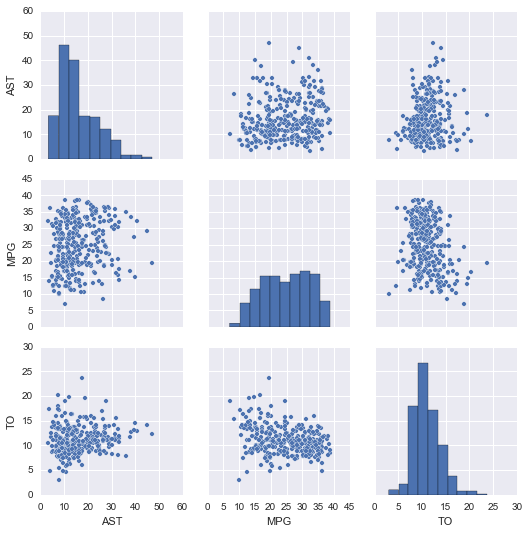

In [6]:
%matplotlib inline
import seaborn as sns


sns.pairplot(nba[["AST", "MPG", "TO"]])

In Python, `matplotlib` is the primary plotting package, and `seaborn` is a widely used layer over matplotlib. You could have also used the `pandas` `scatter_matrix` for a similar result. 

## Make Clusters of the Players 

One good way to explore this kind of data is to generate cluster plots. These will show which players are most similar. Use Scikit-Learn to cluster the data. 

In [7]:
from sklearn.cluster import KMeans 

kmeans_model = KMeans(n_clusters=5, random_state=1)
good_columns = nba._get_numeric_data().dropna(axis=1)
kmeans_model.fit(good_columns)
labels = kmeans_model.labels_

We can use the main Python machine learning package, `scikit-learn`, to fit a `k-means` clustering model and get our cluster labels. In order to cluster properly, we remove any non-numeric columns, or columns with missing values (NA, Nan, etc) with the `get_numeric_data` and `dropna` methods.

## Plot Players by Cluster

We can now plot out the players by cluster to discover patterns. One way to do this is to first use PCA to make our data 2-dimensional, then plot it, and shade each point according to cluster association.

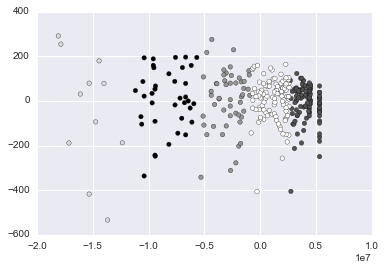

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(good_columns)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)

With Python, we used the PCA class in the scikit-learn library. We used matplotlib to create the plot.

## Split into Training and Testing Sets

If we want to do supervised machine learning, it’s a good idea to split the data into training and testing sets so we don’t overfit.

In [10]:
train = nba.sample(frac=0.8, random_state=1)
test = nba.loc[~nba.index.isin(train.index)]

In Python, the recent version of pandas came with a sample method that returns a certain proportion of rows randomly sampled from a source dataframe – this makes the code much more concise. We could also use Scikit-Learns `KFolds` and `train_test_splits` for different types of shuffle and splits in the data set. In both cases, we set a random seed to make the results reproducible.

## Univariate Linear Regression 

Let’s say we want to predict number of assists per player from the turnovers made per player.

In [11]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train[["TO"]], train["AST"])
predictions = lr.predict(test[["TO"]])

Scikit-learn has a linear regression model that we can fit and generate predictions from. Note also the use of Lasso and Ridge regressions, though this doesn't apply in the univariate case. 

## Calculate Summary Statistics for the Model

Evaluate the above model using your test set, how well does it perform?

In [12]:
import statsmodels.formula.api as sm

model = sm.ols(formula='AST ~ TO', data=train)
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AST   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     5.116
Date:                Fri, 11 Dec 2015   Prob (F-statistic):             0.0245
Time:                        15:18:37   Log-Likelihood:                -889.55
No. Observations:                 258   AIC:                             1783.
Df Residuals:                     256   BIC:                             1790.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     11.3646      1.931      5.884      0.000         7.561    15.168
TO             0.3786      0.167      2.262      0.025         0.049     0.708
==============================================================================
Omnibus:                       28.746   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.916
Skew:                           0.878   Prob(JB):                     2.62e-08
Kurtosis:                       3.403   Cond. No.                         47.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we want to get summary statistics about the fit, like r-squared value, we can use the `score` method of the Sckit-Learn model. However, if we want more advanced regression statistics we’ll need to do a bit more. The `statsmodels` package enables many statistical methods to be used in Python and is a good tool to know.

## Fit a Random Forest Model 

Our linear regression worked well in the single variable case, but we suspect there may be nonlinearities in the data. Thus, we want to fit a random forest model.

In [17]:
from sklearn.ensemble import RandomForestRegressor
predictor_columns = ["AGE", "MPG", "TO", "HT", "WT", "REBR"]
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)
rf.fit(train[predictor_columns], train["AST"])
predictions = rf.predict(test[predictor_columns])

## Calculate Error

Now that we’ve fit two models, let’s calculate error. We’ll use MSE.

In [18]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test["AST"], predictions)

35.794921322323709

The scikit-learn library has a variety of error metrics that we can use

## Download a Webpage

Now that we have data on NBA players from 2013-2014, let’s scrape some additional data to supplement it. We’ll just look at one box score from the NBA Finals here to save time.

In [19]:
import requests
url = "http://www.basketball-reference.com/boxscores/201506140GSW.html"
data = requests.get(url).content

## Extract Player Box Scores

Now that we have the web page, we’ll need to parse it to extract scores for players.

In [21]:
from bs4 import BeautifulSoup
import re
soup = BeautifulSoup(data, 'html.parser')
box_scores = []
for tag in soup.find_all(id=re.compile("[A-Z]{3,}_basic")):
    rows = []
    for i, row in enumerate(tag.find_all("tr")):
        if i == 0:
            continue
        elif i == 1:
            tag = "th"
        else:
            tag = "td"
        row_data = [item.get_text() for item in row.find_all(tag)]
        rows.append(row_data)
    box_scores.append(rows)

print box_scores

[[[u'Starters', u'MP', u'FG', u'FGA', u'FG%', u'3P', u'3PA', u'3P%', u'FT', u'FTA', u'FT%', u'ORB', u'DRB', u'TRB', u'AST', u'STL', u'BLK', u'TOV', u'PF', u'PTS', u'+/-'], [u'LeBron James', u'44:46', u'15', u'34', u'.441', u'3', u'8', u'.375', u'7', u'9', u'.778', u'1', u'13', u'14', u'11', u'1', u'0', u'2', u'5', u'40', u'-11'], [u'Matthew Dellavedova', u'41:41', u'2', u'9', u'.222', u'1', u'5', u'.200', u'0', u'0', u'', u'0', u'0', u'0', u'2', u'3', u'0', u'2', u'4', u'5', u'-19'], [u'Tristan Thompson', u'39:49', u'6', u'11', u'.545', u'0', u'0', u'', u'7', u'10', u'.700', u'5', u'5', u'10', u'0', u'2', u'2', u'1', u'4', u'19', u'-22'], [u'Iman Shumpert', u'37:18', u'3', u'9', u'.333', u'3', u'6', u'.500', u'1', u'2', u'.500', u'3', u'2', u'5', u'2', u'1', u'0', u'1', u'4', u'10', u'-10'], [u'Timofey Mozgov', u'9:19', u'0', u'1', u'.000', u'0', u'0', u'', u'0', u'0', u'', u'0', u'0', u'0', u'0', u'1', u'0', u'2', u'2', u'0', u'-4'], [], [u'J.R. Smith', u'35:42', u'5', u'15', u'.333',

This will create a list containing two lists, the first with the box score for CLE, and the second with the box score for GSW. Both contain the headers, along with each player and their in-game stats. We won’t turn this into more training data now, but it could easily be transformed into a format that could be added to our nba dataframe.

BeautifulSoup, the most commonly used web scraping package. It enables us to loop through the tags and construct a list of lists in a straightforward way.